# Train Travel Time and Cost Analysis

This notebook analyzes train travel times and costs for trips to and from TU Delft campus. It includes:
- Basic fare calculations
- Travel time analysis including bike transfer time
- Monthly cost calculations with different subscription options
- Visualization of results using bar charts and scatter plots

## Import Required Libraries

First, we'll import all the necessary Python libraries for data manipulation, calculations, and visualization.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import os
import seaborn as sns

# Set up matplotlib style for nice looking plots
plt.style.use('seaborn-v0_8')
NS_YELLOW = '#FFD400'  # NS corporate yellow for plots

## Load and Prepare Data

We'll load the train data from our processed data folder and prepare it for analysis. This includes:
1. Loading the CSV file
2. Cleaning column names
3. Converting data types

In [2]:
# Load data from processed_data folder
data_file = os.path.join('..', 'base data', 'TrainDistancesDelft_NSPrices_NSTravelTime.csv')
df = pd.read_csv(data_file)

# Clean column names
df.columns = [c.strip() for c in df.columns]
df = df.rename(columns={
    'Distance (km)': 'distance_km',
    'NS 2nd class fare (€) (no subscription, e-ticket)': 'ns_fare_eur',
    'travel time (min)': 'travel_time_min',
    'City': 'city'  # ensure City header is normalized to lowercase
})

# Convert to numeric types
df['distance_km'] = pd.to_numeric(df['distance_km'], errors='coerce')
df['ns_fare_eur'] = pd.to_numeric(df['ns_fare_eur'], errors='coerce')
df['travel_time_min'] = pd.to_numeric(df['travel_time_min'], errors='coerce')

# Display the first few rows
print("Train data columns (city, distance_km, ns_fare_eur, travel_time_min):")
wanted = ['city', 'distance_km', 'ns_fare_eur', 'travel_time_min']
print(df[wanted].head().to_string(index=False))

Train data columns (city, distance_km, ns_fare_eur, travel_time_min):
     city  distance_km  ns_fare_eur  travel_time_min
Amsterdam           67         16.3               67
Rotterdam           13          4.1               13
The Hague           12          3.3               15
  Utrecht           67         15.7               56
Eindhoven          130         24.4               75


## Helper Functions

Define helper functions for cost and time calculations:

In [3]:
def train_cost_per_city(df: 'pd.DataFrame') -> 'pd.Series':
    """Return train cost (NS 2nd class fare) per city as a Series indexed by city.

    The function expects the DataFrame to contain a 'city' column and 'ns_fare_eur'.
    """
    if 'city' not in df.columns or 'ns_fare_eur' not in df.columns:
        raise KeyError("DataFrame must contain 'city' and 'ns_fare_eur' columns")
    # Return a copy to avoid accidental modifications
    return df.set_index('city')['ns_fare_eur'].copy()

def Train_Travel_Time_per_city(df: 'pd.DataFrame') -> 'pd.Series':
    """Return train travel time per city (minutes).

    Adds 10 minutes to the reported train travel time to represent the bike
    transfer from Delft station to campus (one-way). Returns minutes as numeric.
    """
    if 'city' not in df.columns or 'travel_time_min' not in df.columns:
        raise KeyError("DataFrame must contain 'city' and 'travel_time_min' columns")
    base = pd.to_numeric(df['travel_time_min'], errors='coerce')
    # add 10 minutes one-way for the bike transfer to/from campus
    total = base + 10
    return pd.Series(total.values, index=df['city'].values, name='train_travel_time_min')

# Test the functions and print results
print("Train cost per city (EUR):")
costs = train_cost_per_city(df)
print(costs.to_string())

print("\nTrain travel time per city (minutes, including bike transfer):")
times = Train_Travel_Time_per_city(df)
print(times.to_string())

Train cost per city (EUR):
city
Amsterdam     16.3
Rotterdam      4.1
The Hague      3.3
Utrecht       15.7
Eindhoven     24.4
Tilburg       18.8
Almere        20.1
Groningen     31.2
Breda         14.7
Nijmegen      26.7
Leeuwarden    31.2
Maastricht    31.2

Train travel time per city (minutes, including bike transfer):
Amsterdam      77
Rotterdam      23
The Hague      25
Utrecht        66
Eindhoven      85
Tilburg        60
Almere        100
Groningen     190
Breda          45
Nijmegen      130
Leeuwarden    190
Maastricht    159


## Visualization Helper Functions

Define functions for creating bar charts and scatter plots with consistent styling:

In [4]:
def compute_ticks(minv, maxv, target_ticks=8):
    """Compute 'nice' ticks between minv and maxv aiming for ~target_ticks ticks."""
    if math.isnan(minv) or math.isnan(maxv):
        return []
    if minv == maxv:
        if minv == 0:
            minv, maxv = 0, 1
        else:
            minv = minv - abs(minv) * 0.1
            maxv = maxv + abs(maxv) * 0.1
    rng = maxv - minv
    if rng == 0:
        rng = abs(maxv) if maxv != 0 else 1
    raw_step = rng / max(1, target_ticks - 1)
    exp = math.floor(math.log10(raw_step))
    base = 10 ** exp
    lead = raw_step / base
    if lead <= 1.5:
        nice = 1 * base
    elif lead <= 3:
        nice = 2 * base
    elif lead <= 7:
        nice = 5 * base
    else:
        nice = 10 * base
    start = math.floor(minv / nice) * nice
    stop = math.ceil(maxv / nice) * nice
    ticks = np.arange(start, stop + nice / 2, nice)
    return ticks

def simple_bar(values, city_names, ylabel, title, fname):
    """Create a simple bar chart with cities on x-axis."""
    plt.figure(figsize=(10, 5))
    bars = plt.bar(city_names, values, color=NS_YELLOW, edgecolor='k')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True, axis='y')
    
    # Set sensible y ticks
    ymin, ymax = plt.ylim()
    yticks = compute_ticks(ymin, ymax, target_ticks=6)
    if len(yticks) > 0:
        plt.yticks(yticks)

    # Format labels based on data type
    fmt = '{:.0f}'
    if 'EUR' in ylabel or 'Cost' in title:
        fmt = '{:.2f}'
    elif 'minutes' in ylabel or 'time' in ylabel.lower():
        fmt = '{:.0f}'
    elif 'km' in ylabel or 'Distance' in title:
        fmt = '{:.0f}'

    # Add value labels on bars
    for bar in bars:
        h = bar.get_height()
        if np.isnan(h):
            label = ''
        else:
            try:
                label = fmt.format(h)
            except Exception:
                label = str(h)
        plt.text(bar.get_x() + bar.get_width() / 2, h + (ymax - ymin) * 0.01, label,
                ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.savefig(f"../figures/Train/{fname}")
    return plt.gcf()

def simple_scatter(x, y, labels, xlabel, ylabel, title):
    """Create a scatter plot with city name labels."""
    plt.figure(figsize=(7, 5))
    plt.scatter(x, y, c=NS_YELLOW, edgecolors='k')
    
    # Smart label placement
    try:
        xr = float(np.nanmax(x) - np.nanmin(x))
        yr = float(np.nanmax(y) - np.nanmin(y))
    except Exception:
        xr = 1.0
        yr = 1.0
    if xr == 0: xr = 1.0
    if yr == 0: yr = 1.0
    
    threshold = math.hypot(xr * 0.06, yr * 0.06)
    placed = []
    for i, (xi, yi, lab) in enumerate(zip(x, y, labels)):
        close_count = sum(1 for (xj, yj) in placed if math.hypot(xi - xj, yi - yj) < threshold)
        vstep = yr * 0.04
        yoff = 0 if close_count == 0 else (1 if close_count % 2 == 1 else -1) * ((close_count + 1) // 2) * vstep
        xoff = xr * 0.015
        plt.text(xi + xoff, yi + yoff, lab, fontsize=7)
        placed.append((xi, yi))
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    return plt.gcf()

## Data Processing and Analysis

Let's calculate monthly costs and times based on:

### Configuration Parameters

Set up the key parameters for our analysis:

In [5]:
# Days per month (average working days to Delft)
DAYS_PER_MONTH = 18

# Monthly bike cost at Delft station
MONTHLY_BIKE_COST = 17.90
DAILY_BIKE_COST = MONTHLY_BIKE_COST / 30.0

# Subscription options
DALUREN_ENABLED = False  # 40% discount outside peak hours
DALUREN_COST_PER_MONTH = 5.90
DALUREN_DISCOUNT = 0.40

ALTIJD_KORTING_ENABLED = True  # 20% discount during peak hours
ALTIJD_COST_PER_MONTH = 28.50
ALTIJD_PEAK_DISCOUNT = 0.20

# Create output directory for figures
FIG_DIR = os.path.join('..', 'figures', 'train')
os.makedirs(FIG_DIR, exist_ok=True)

### Calculate Monthly Values

Calculate monthly travel times and costs based on daily round trips:

In [6]:
# Prepare data for plotting
plot_df = df[['city', 'distance_km', 'ns_fare_eur', 'travel_time_min']].dropna()
cities = plot_df['city'].astype(str).values
distance = plot_df['distance_km'].values
cost = plot_df['ns_fare_eur'].values
time = plot_df['travel_time_min'].values + 10  # add 10 minutes for bike transfer

# Calculate round-trip values
time_rt = time * 2
distance_rt = distance * 2
cost_rt = cost * 2 + DAILY_BIKE_COST  # add daily bike cost

# Calculate monthly values
time_month = time_rt * DAYS_PER_MONTH
distance_month = distance_rt * DAYS_PER_MONTH
cost_month = cost_rt * DAYS_PER_MONTH

# Create summary DataFrame
summary_df = pd.DataFrame({
    'city': cities,
    'time_per_month_min': time_month,
    'cost_per_month_eur': cost_month
})

print("Monthly Summary (first few rows):")
print(summary_df.head().to_string(index=False))

Monthly Summary (first few rows):
     city  time_per_month_min  cost_per_month_eur
Amsterdam                2772              597.54
Rotterdam                 828              158.34
The Hague                 900              129.54
  Utrecht                2376              575.94
Eindhoven                3060              889.14


### Visualize Results

Create visualizations of our analysis:

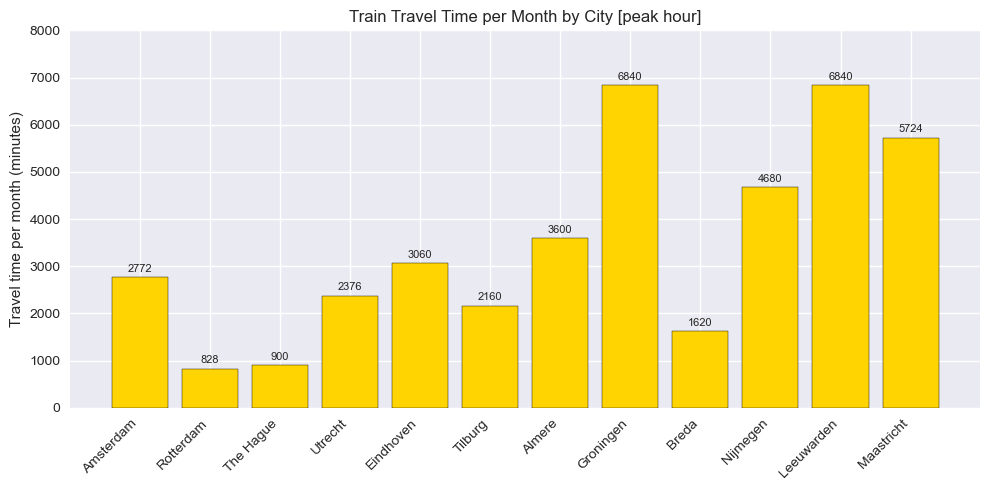

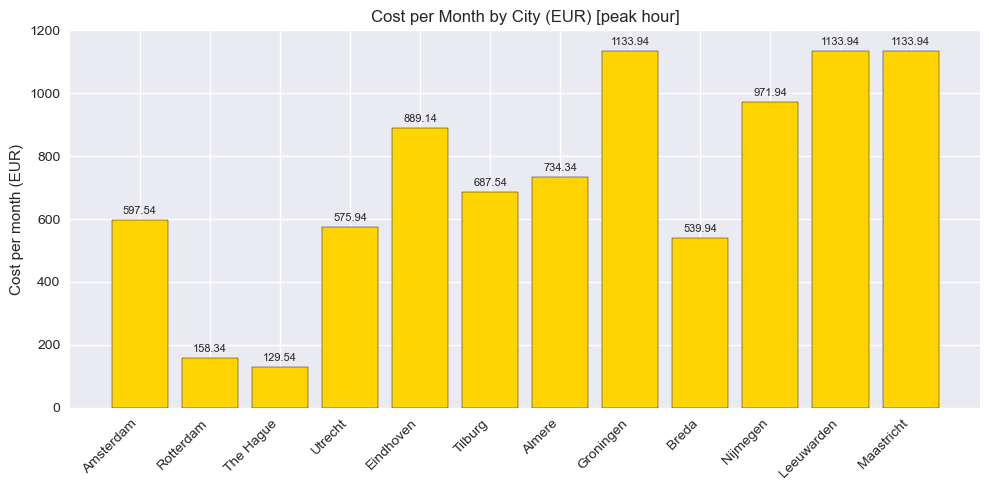

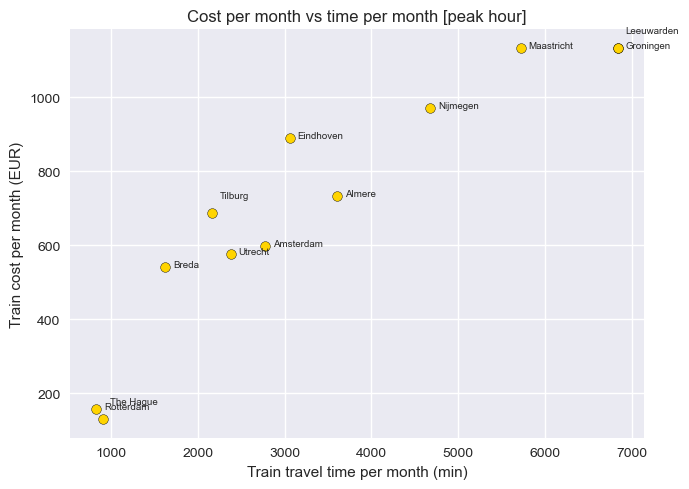

In [7]:
# 1. Monthly travel time bar chart
fig = simple_bar(time_month, cities, 'Travel time per month (minutes)',
                'Train Travel Time per Month by City [peak hour]', 'time_bars_month_peak.png')
plt.show()

# 2. Monthly cost bar chart
fig = simple_bar(cost_month, cities, 'Cost per month (EUR)',
                'Cost per Month by City (EUR) [peak hour]', 'cost_bars_month_peak.png')
plt.show()

# 3. Cost vs Time scatter plot
fig = simple_scatter(time_month, cost_month, cities,
                    'Train travel time per month (min)', 'Train cost per month (EUR)',
                    'Cost per month vs time per month [peak hour]')
plt.savefig("../figures/Train/cost_month_vs_time_month_peak.png")
plt.show()


### Save Results

Save the monthly summary data to CSV files, including subscription options if enabled:

In [8]:
# Save basic monthly summary
out_file = os.path.join('..', 'processed_data', 'train_monthly_summary.csv')
summary_df.to_csv(out_file, index=False)
print(f"Saved monthly summary CSV: {out_file}")

# Calculate and save DALUREN discount data if enabled
if DALUREN_ENABLED:
    fare = plot_df['ns_fare_eur'].values
    fare_discounted = fare * (1.0 - DALUREN_DISCOUNT)
    cost_rt_daluren = fare_discounted * 2 + DAILY_BIKE_COST
    cost_month_daluren = cost_rt_daluren * DAYS_PER_MONTH + DALUREN_COST_PER_MONTH
    
    daluren_df = pd.DataFrame({
        'city': cities,
        'time_per_month_min': time_month,
        'cost_per_month_eur_daluren': cost_month_daluren
    })
    
    dal_file = os.path.join('..', 'processed_data', 'daluren_40_discount.csv')
    daluren_df.to_csv(dal_file, index=False)
    print(f"Saved DALUREN 40% discount CSV: {dal_file}")

# Calculate and save ALTIJD KORTING discount data if enabled
if ALTIJD_KORTING_ENABLED:
    fare = plot_df['ns_fare_eur'].values
    fare_discounted_peak = fare * (1.0 - ALTIJD_PEAK_DISCOUNT)
    cost_rt_altijd = fare_discounted_peak * 2 + DAILY_BIKE_COST
    cost_month_altijd = cost_rt_altijd * DAYS_PER_MONTH + ALTIJD_COST_PER_MONTH
    
    altijd_df = pd.DataFrame({
        'city': cities,
        'time_per_month_min': time_month,
        'cost_per_month_eur_altijd_peak20': cost_month_altijd
    })
    
    altijd_file = os.path.join('..', 'processed_data', 'altijd_20_peak_discount.csv')
    altijd_df.to_csv(altijd_file, index=False)
    print(f"Saved ALTIJD 20% peak discount CSV: {altijd_file}")

Saved monthly summary CSV: ..\processed_data\train_monthly_summary.csv
Saved ALTIJD 20% peak discount CSV: ..\processed_data\altijd_20_peak_discount.csv
